# A/B Testing 

For this exercise, we have an A/B test dataset that ran in several countries and we need to derive conclusions from it.

First things first, let's have a look at it 

### Import and read the data

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math 
%matplotlib inline 

In [111]:
data_ab = pd.read_csv("../data/ex2_ab_test.csv")

In [112]:
data_ab.head()

,Unnamed: 0,trials_A,successes_A,trials_B,successes_B
0,Country_1,8251,512,1084,89
1,Country_2,5604,353,257,17
2,Country_3,3252,120,5931,202
3,Country_4,4174,138,3758,131
4,Country_5,1918,53,3939,94


In [113]:
data_ab.describe()

,trials_A,successes_A,trials_B,successes_B
count,6.000000,6.000000,6.000000,6.000000
mean,4488.333333,199.666667,3063.500000,92.833333
std,2200.448379,191.984027,2068.221531,69.106922
min,1918.000000,22.000000,257.000000,17.000000
25%,3371.750000,69.750000,1666.000000,40.250000
50%,3952.500000,129.000000,3585.000000,91.500000
75%,5246.500000,299.250000,3893.750000,121.750000
max,8251.000000,512.000000,5931.000000,202.000000


We have trials and successes for group A and group B for each country. Let's assume that VC is testing a new feature on its website and it is doing so by having a control group A (traditional website) and a trial group (group B) where the new feature is presented to the customers. 

First things first, let's calculate the conversion rate since it is going to be the indicator that we are going to use in order to determine if method B is better

In [117]:
data_ab.rename(columns={"Unnamed: 0":"country"}, inplace=True)
data_ab["conversion_rate_A"] = data_ab["successes_A"] / data_ab["trials_A"]
data_ab["conversion_rate_B"] = data_ab["successes_B"] / data_ab["trials_B"]

In [118]:
data_ab

,country,trials_A,successes_A,trials_B,successes_B,conversion_rate_A,conversion_rate_B
0,Country_1,8251,512,1084,89,0.062053,0.082103
1,Country_2,5604,353,257,17,0.062991,0.066148
2,Country_3,3252,120,5931,202,0.036900,0.034058
3,Country_4,4174,138,3758,131,0.033062,0.034859
4,Country_5,1918,53,3939,94,0.027633,0.023864
5,Country_6,3731,22,3412,24,0.005897,0.007034


At first sight we could be tempted to say that method B performed super well on country 1, 2, 4 and 6 but that is **NOT statistically approuved** 

In fact, in order to be statistically approuved, we need to modelize the distribution for each country, fix a null hypothesis aanc calculate a the p-value in order to see if the B group performed better than A. 

To do so, we will first fix a null hypothesis which will be **"in terms of CR, Group B is less then or equal than A"** and **a confidence level of 95%** (p-value = 0,05)

As an example, we will take one coutry and modelize it quickly using a normal law 

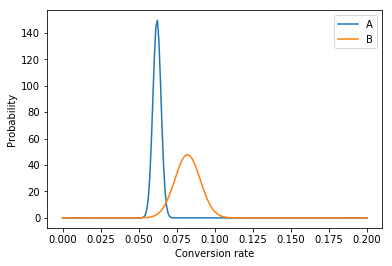

In [144]:
country = "Country_1"
rate_a = data_ab[data_ab["country"] == country].conversion_rate_A.values[0]
rate_b = data_ab[data_ab["country"] == country].conversion_rate_B.values[0]

trials_a = data_ab[data_ab["country"] == country].trials_A.values[0]
trials_b = data_ab[data_ab["country"] == country].trials_B.values[0]

std_a = np.sqrt(rate_a * (1 - rate_a) / trials_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / trials_b)

click_rate = np.linspace(0, 0.2, 200)
prob_a = stats.norm(rate_a, std_a).pdf(click_rate)
prob_b = stats.norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.xlabel("Conversion rate") 
plt.ylabel("Probability")
plt.legend()

Since we are interested on the average conversion rate, our approximation is well estimated by a normal distribution. The above plot is showing the probability that the actual conversion rate for A and B was a certain value given the data we collected.

For this specific example, the million dollar question is : what is the chance that the CR of group B is higher than the CR of group A. Let's find out by taking the difference of the means ans by summing the variance 

z-score is 2.291, with p-value 0.011


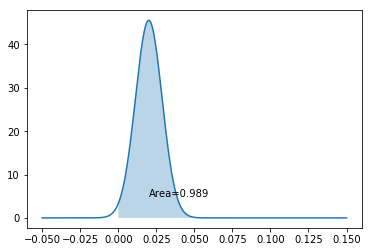

In [145]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
print(f"z-score is {z_score:0.3f}, with p-value {stats.norm().sf(z_score):0.3f}")

p = stats.norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))
x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))

Using the frequentist approach we would say that given the null hypothesis (that group B is less then or equal to group A) we would get this result 1% of the time. Since p_value < 5%, the hypothesis is reject => **Group B is performing better than Group A on country 1**

Now that we have done it for one country, we will replicate the same strategy for all the others. First let's create a function in order to compute the p-value / confidence 

In [146]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b, type="confidence"):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    if type == "confidence":
        return stats.norm.cdf(z_score)
    else :
        return stats.norm.sf(z_score)

In [150]:
data_ab["confidence"] = data_ab.apply(lambda x: get_confidence_ab_test(x["successes_A"], 
                                                                         x["trials_A"], 
                                                                         x["successes_B"], 
                                                                         x["trials_B"]), axis=1)

data_ab["p_value"] = data_ab.apply(lambda x: get_confidence_ab_test(x["successes_A"], 
                                                                         x["trials_A"], 
                                                                         x["successes_B"], 
                                                                         x["trials_B"],
                                                                   type="p_value"), axis=1)

data_ab["best_group"] = data_ab.apply(lambda x : "B" if x["p_value"]<0.05 else "A", axis = 1)

In [151]:
data_ab

,country,trials_A,successes_A,trials_B,successes_B,conversion_rate_A,conversion_rate_B,confidence,p_value,best_group
0,Country_1,8251,512,1084,89,0.062053,0.082103,0.989025,0.010975,B
1,Country_2,5604,353,257,17,0.062991,0.066148,0.578994,0.421006,A
2,Country_3,3252,120,5931,202,0.036900,0.034058,0.241905,0.758095,A
3,Country_4,4174,138,3758,131,0.033062,0.034859,0.670372,0.329628,A
4,Country_5,1918,53,3939,94,0.027633,0.023864,0.199220,0.800780,A
5,Country_6,3731,22,3412,24,0.005897,0.007034,0.725075,0.274925,A


### Conclusion 

I would recommend deploying the B version of the website on country 1 and leaving the A version on the other countries 